In [1]:
%load_ext autoreload
%autoreload 2

In [11]:
import os
import sys
parent_dir_abs = os.path.abspath(os.pardir)
sys.path.insert(0, parent_dir_abs) 

import torch
import torch.nn as nn

import numpy as np
import pandas as pd
from scipy.stats import norm
from urllib.request import urlopen

import pyro
from pyro import poutine
from pyro import distributions as dist
from pyro_oed_src import posterior_loss
from pyro.contrib.util import lexpand, rexpand
from pyro.infer import SVI, Trace_ELBO, TraceGraph_ELBO
from pyro.optim import Adam, ClippedAdam
from pyro_oed_src import _eig_from_ape, posterior_loss
from pyro.nn import PyroModule

import matplotlib.pyplot as plt

import neural_nets
import flows
from guides import dense_nn

In [3]:
device = torch.device("cuda:0") if torch.cuda.is_available() else "cpu"
#device = "cpu"
print(f'Using device: {device}.')

#set default dtype
torch.set_default_dtype(torch.float64)

Using device: cuda:0.


In [4]:
np_dtype = np.float64
redshifts = np.arange(0, 5, 0.2, dtype=np_dtype)
designs = torch.tensor(redshifts).to(device)
designs[0:5]

tensor([0.0000, 0.2000, 0.4000, 0.6000, 0.8000], device='cuda:0')

In [5]:
om_prior = torch.tensor(0.31, device=device) # Gaussian prior mean
sigma_prior = torch.tensor(0.02, device=device) # Gaussian prior std
sig = torch.tensor(0.2, device=device) # Gaussian likelihood std

def model(z, y=None):
    with pyro.plate_stack("plate", z.shape):
        om = pyro.sample("om", dist.Normal(om_prior,sigma_prior)) # shape: [n,num_designs,1]
        mean = 29.09/torch.sqrt(om*(1+z)**3+(1-om))
        return pyro.sample("y", dist.Normal(mean, sig))

In [12]:
class cosmo_posterior(PyroModule):
    def __init__(self, in_features, lay1_out, lay2_out, lay3_out, out_features, device, amor_design=False, batch_norm=False):
        super().__init__()
        self.device = device
        self.amor_design = amor_design

        self.in_features = in_features
        self.out_features = out_features

        self.nn = dense_nn(self.in_features, lay1_out, lay2_out, lay3_out, out_features, device)

        if batch_norm:
            self.rate_nn.insert_layer(nn.BatchNorm1d(lay1_out).to(device), 1)
            self.rate_nn.insert_layer(nn.BatchNorm1d(lay2_out).to(device), 4)
            self.rate_nn.insert_layer(nn.BatchNorm1d(lay3_out).to(device), 7)
    def forward(self, design, y_dict):
        y = y_dict["y"] # shape: [n,num_designs]
        if self.amor_design:
            # reshape the input data to include all y values in one dimension
            input_data = torch.cat((y.unsqueeze(-1), design.unsqueeze(-1)), dim=-1)
            x = torch.flatten(input_data, start_dim=0, end_dim=len(design.shape)-1)
        else:
            x = torch.flatten(y, start_dim=0, end_dim=1)
        x = self.nn(x)
        x = x.reshape(y_dict["y"].shape[0],-1, self.out_features) # shape: [n,num_designs,2]
        mean = x[...,0]
        sigma = x[...,1]
        posterior_mean = pyro.param("posterior_mean", torch.tensor(mean, device=self.device))
        posterior_sigma = pyro.param("posterior_sigma", torch.tensor(sigma, device=self.device), constraint=dist.constraints.positive)
        pyro.sample("om", dist.Normal(posterior_mean, posterior_sigma))

In [13]:
pyro.clear_param_store()
pyro.set_rng_seed(18)
z_data = torch.tensor([0.698, 2.330], device=device).unsqueeze(0)
y_data = torch.tensor([19.770, 8.99], device=device).unsqueeze(0)
y_uncertainty = torch.tensor([0.47, 0.19], device=device).unsqueeze(0)
lay_1 = 4
lay_2 = 8
lay_3 = 8
input_features = 2
output_features = 2
guide = cosmo_posterior(input_features, lay_1, lay_2, lay_3, output_features, device, amor_design=True, batch_norm=False)
mean_vals = []
sigma_vals = []
for i in range(z_data.shape[1]):
    z_measure = z_data[...,i]
    y_measure = y_data[...,i]
    print(z_measure, y_measure)
    svi = SVI(model,
              guide,
              ClippedAdam({"lr": 1e-3}),
              loss=TraceGraph_ELBO(),
              num_samples=100)
    num_iters = 2000
    for j in range(num_iters):
        y_sample = y_measure + torch.randn_like(y_measure)*y_uncertainty[...,i]
        #print(i)
        elbo = svi.step(z_measure, {"y": y_sample})
        if j % 500 == 0:
            print("Neg ELBO:", elbo)
    mean = pyro.param("posterior_mean").squeeze().detach().cpu().numpy()
    sigma = pyro.param("posterior_sigma").squeeze().detach().cpu().numpy()
    mean_vals.append(mean)
    sigma_vals.append(sigma)

tensor([0.6980], device='cuda:0') tensor([19.7700], device='cuda:0')


/home/ashandonay/.local/lib/python3.8/site-packages/pyro/infer/svi.py:57: FutureWarning: The `num_samples` argument to SVI is deprecated and will be removed in a future release. Use `pyro.infer.Predictive` class to draw samples from the posterior.
  warnings.warn(
<ipython-input-12-718d2a9db49b>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior_mean = pyro.param("posterior_mean", torch.tensor(mean, device=self.device))
<ipython-input-12-718d2a9db49b>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior_sigma = pyro.param("posterior_sigma", torch.tensor(sigma, device=self.device), constraint=dist.constraints.positive)
/home/ashandonay/.local/lib/python3.8/site-packages/py

Neg ELBO: 13.983412422059581
Neg ELBO: 28.517738502859046
Neg ELBO: 3.1771777619610746
Neg ELBO: -1.519876901731831
tensor([2.3300], device='cuda:0') tensor([8.9900], device='cuda:0')
Neg ELBO: -1.4533148062558023
Neg ELBO: -0.44109658276539543
Neg ELBO: -0.21106685781261336
Neg ELBO: -0.35863160355281076


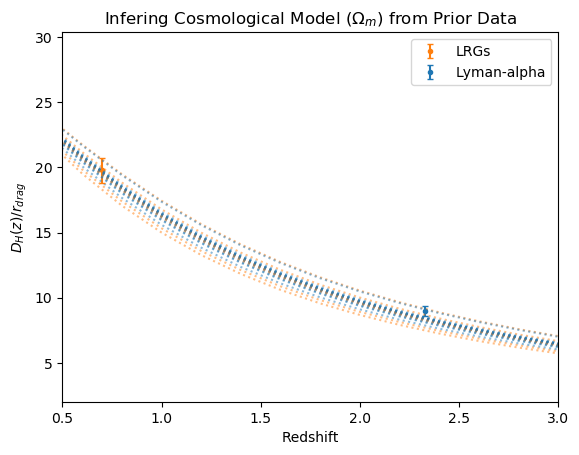

In [14]:
colors = ['#ff7f0e', '#1f77b4']
for x in range(len(mean_vals)):
    posterior_mean = torch.tensor(mean_vals[x], device=device)
    posterior_sigma = torch.tensor(sigma_vals[x], device=device)
    num_samples = 10
    samples = dist.Normal(posterior_mean, posterior_sigma).sample((num_samples,))
    # set line style to dotted
    for i in range(len(samples)):
        data = 29.09/torch.sqrt(samples[i]*(1+designs)**3+(1-samples[i]))
        plt.plot(designs.cpu().numpy(), data.cpu().detach().numpy(), ':', color=colors[x], alpha=0.5)

# plot point with error bars using default matplotlib colors
plt.errorbar(z_data.squeeze()[0].cpu().numpy(), y_data.squeeze()[0].cpu().numpy(), yerr=2*y_uncertainty.squeeze()[0].cpu().numpy(), label='LRGs', barsabove=True, capsize=2, fmt='.', color='#ff7f0e')
plt.errorbar(z_data.squeeze()[1].cpu().numpy(), y_data.squeeze()[1].cpu().numpy(), yerr=2*y_uncertainty.squeeze()[1].cpu().numpy(), label='Lyman-alpha', barsabove=True, capsize=2, fmt='.', color='#1f77b4')
#plt.plot(z, 29.09/np.sqrt(om*(1+z)**3+(1-om)), label='Fiducial Cosmology', color="black")
plt.legend()
plt.xlabel('Redshift')
plt.ylabel('$D_H(z)/r_{drag}$')
plt.title("Infering Cosmological Model ($\Omega_m$) from Prior Data")
plt.xlim(0.5, 3)
plt.show()

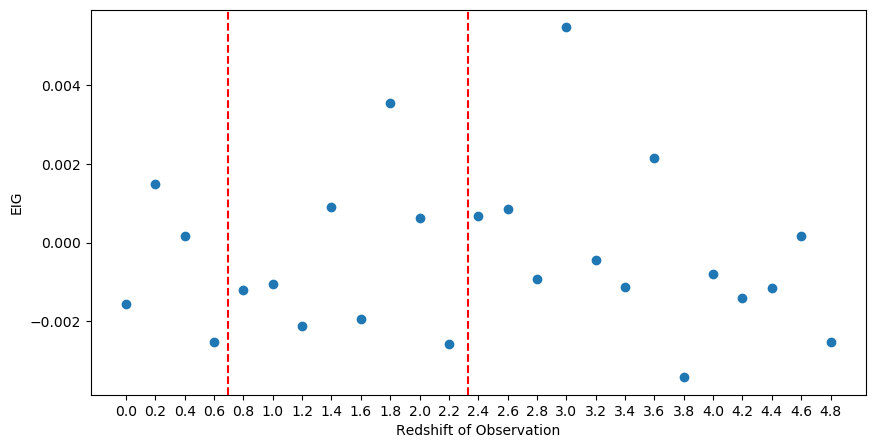

In [7]:
observation_labels = ["y"]
target_labels = ["om"]
N = 1000
training_steps = 30000
params = None
return_history = True
history = []
optim = pyro.optim.Adam({"lr": 5e-3})

for step in range(training_steps):
    if params is not None:
        pyro.infer.util.zero_grads(params)
    with poutine.trace(param_only=True) as param_capture:
        agg_loss, loss = posterior_loss(design=designs,
                                        model=model,
                                        guide=guide,
                                        num_particles=N,
                                        observation_labels=observation_labels,
                                        target_labels=target_labels)
    params = set(
        site["value"].unconstrained() for site in param_capture.trace.nodes.values())
    if torch.isnan(agg_loss):
        raise ArithmeticError("Encountered NaN loss in opt_eig_ape_loss")
    agg_loss.backward(retain_graph=True)
    if return_history:
        history.append(loss)
    optim(params)
    try:
        optim.step()
    except AttributeError:
        pass

    history.append(loss)

stacked_history = torch.stack(history)
history_array = stacked_history.cpu().detach().numpy()

eigs = []
for i in range(len(designs)):
    _, ape = posterior_loss(designs[i].unsqueeze(0), model, guide, 100000, observation_labels, target_labels)
    eigs.append(_eig_from_ape(model, designs[i].unsqueeze(0), target_labels, ape, True, {}).item())
eigs = np.array(eigs)

plt.figure(figsize=(10,5))
plt.plot(redshifts, eigs, 'o')
# plot vertical line of the previous measurements
plt.axvline(x=0.698, color='r', linestyle='--')
plt.axvline(x=2.330, color='r', linestyle='--')
plt.xticks(np.round(redshifts, 2))
plt.xlabel("Redshift of Observation")
plt.ylabel("EIG")
plt.show()